#                                         Lending Club Loan Data

## Import Data

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

In C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\miniconda3\envs

In [3]:
SAMPLE = True

In [4]:
loans = pd.read_csv('../project_1/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True) #Load data into pandas

if SAMPLE:
    loans = loans.sample(frac=0.01)

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22607 entries, 1323446 to 41791
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 26.2+ MB


In [6]:
pd.options.display.float_format = '{:,.2f}'.format 

In [7]:
loans.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1323446,12435459,nan,"26,050.00","26,050.00","26,050.00",60 months,16.59,641.69,D,D1,Store manager,10+ years,MORTGAGE,"110,000.00",Verified,Feb-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=12435459,NaN,debt_consolidation,Debt consolidation,496xx,MI,25.20,0.00,Nov-1999,690.00,694.00,0.00,nan,nan,10.00,0.00,"35,699.00",55.30,35.00,w,0.00,0.00,"35,899.65","35,899.65","26,050.00","9,849.65",0.00,0.00,0.00,Dec-2016,"14,739.85",NaN,Jul-2017,719.00,715.00,0.00,nan,1.00,Individual,nan,nan,NaN,0.00,0.00,"305,574.00",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"64,600.00",nan,nan,nan,8.00,"30,557.00","28,323.00",52.60,0.00,0.00,171.00,170.00,4.00,4.00,7.00,4.00,nan,8.00,nan,0.00,3.00,5.00,4.00,7.00,12.00,7.00,15.00,5.00,10.00,0.00,0.00,0.00,5.00,100.00,75.00,0.00,0.00,"355,180.00","66,015.00","59,800.00","48,425.00",nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
2056641,125828259,nan,"4,600.00","4,600.00","4,600.00",36 months,5.32,138.53,A,A1,Laborer,10+ years,MORTGAGE,"44,000.00",Not Verified,Dec-2017,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=125828259,NaN,home_improvement,Home improvement,891xx,NV,18.93,0.00,Nov-2004,805.00,809.00,0.00,nan,nan,9.00,0.00,"4,385.00",13.70,25.00,w,"2,771.88","2,771.88","2,082.03","2,082.03","1,828.12",253.91,0.00,0.00,0.00,Mar-2019,138.53,Apr-2019,Mar-2019,824.00,820.00,0.00,nan,1.00,Joint App,"72,000.00",12.50,Not Verified,0.00,0.00,"189,980.00",1.00,2.00,1.00,2.00,5.00,"19,095.00"

In [8]:
loans.shape

(22607, 151)

## Target Variable

The Target Variable in this loan data is "Loan_Status", which we focus more on either loan status is "Fully Paid" or Charged Off. Will check on value counts of "Loan_Status" variable.

In [9]:
loans['loan_status'].value_counts(dropna=False) 

Fully Paid                                             10890
Current                                                 8723
Charged Off                                             2646
Late (31-120 days)                                       204
In Grace Period                                           78
Late (16-30 days)                                         43
Does not meet the credit policy. Status:Fully Paid        15
Does not meet the credit policy. Status:Charged Off        8
Name: loan_status, dtype: int64

Will exclude the loans which status are in Current,Late (31-120 days),In Grace Period,Late (16-30 days),Does not meet the credit policy. Status:Fully Paid,Does not meet the credit policy. Status:Charged Off,Default and missing status

In [10]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])] #Ignore other loan_status

Loan_Status counts as percentages

In [12]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid    0.80
Charged Off   0.20
Name: loan_status, dtype: float64

80% are Fully Paid, 20% are Charged Off 

## Data Preparation

Drop columns with >30% data missing

Calculate the missing data percentages of each feature

In [13]:
missing_data = loans.isnull().mean().sort_values(ascending=False) #calculate % of missing data

In [14]:
drop_list = sorted(list(missing_data[missing_data > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [15]:
len(drop_list) #Missing data >30% columns

58

In [16]:
loans.drop(labels=drop_list, axis=1, inplace=True) # Drop columns

### Keep variables needed for Investors

In [17]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [18]:
len(keep_list)

31

In [19]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list) #List remaining features not needed for investors

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc

In [20]:
len(drop_list)

62

In [21]:
loans.drop(labels=drop_list, axis=1, inplace=True) #Drop Features

In [22]:
loans.shape #Remaining Columns

(13536, 31)

## Exploratory Data Analysis

Check dtypes of columns 

In [23]:
loans.dtypes

id                       object
loan_amnt               float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
title                    object
zip_code                 object
addr_state               object
dti                     float64
earliest_cr_line         object
fico_range_low          float64
fico_range_high         float64
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                float64
pub_rec_bankruptcies    float64
dtype: o

In [24]:
loans.select_dtypes(include=np.object).columns.tolist() # Object data type columns

['id',
 'term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type']

In [25]:
loans.select_dtypes(include=np.float).columns.tolist() # Float data type columns

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'fico_range_low',
 'fico_range_high',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

### Analyzing Categorical data

id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status',
'issue_d', 'loan_status', 'purpose', 'title',  'zip_code', 'addr_state',  'earliest_cr_line', 'initial_list_status',
'application_type'

#### Id

In [26]:
loans['id'].describe() #Usually ID's are unique and independent keys

count        13536
unique       13536
top       61308926
freq             1
Name: id, dtype: int64

In [27]:
loans.drop('id', axis=1, inplace=True) #drop id

#### Term

In [28]:
loans['term'].value_counts(dropna=False)

 36 months    10336
 60 months     3200
Name: term, dtype: int64

In [29]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0])) #convert them into numericals

In [30]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36   0.16
60   0.32
Name: loan_status, dtype: float64

Charge off rates for 60 months are 2x higher than for 36 months term

#### Grade and Sub Grade

In [31]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [32]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


Both are same, drop one column either grade or sub grade, I am dropping grade column here

In [33]:
loans.drop('grade', axis=1, inplace=True) #Drop grade

In [34]:
def plot_var(col_name, full_name, continuous):  # plot function
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


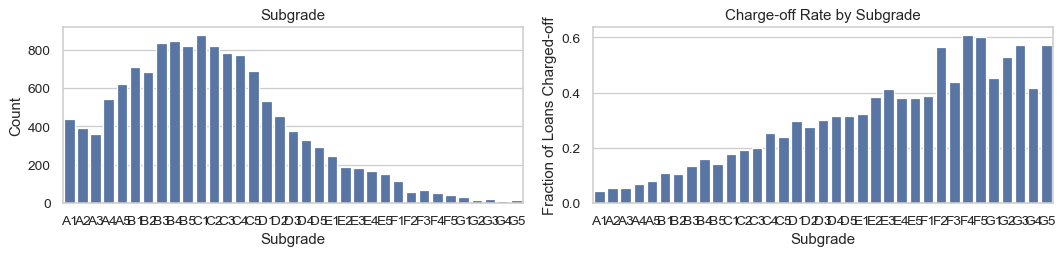

In [35]:
plot_var('sub_grade', 'Subgrade', continuous=False)

From the above plot, we can find that charge off rates increases with sub grade

#### Employment title

In [36]:
loans['emp_title'].describe()

count       12711
unique       7984
top       Teacher
freq          187
Name: emp_title, dtype: object

In [37]:
loans.drop(labels='emp_title', axis=1, inplace=True) #too many unique values

#### Employment length

In [38]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        928
10+ years    4453
2 years      1255
3 years      1050
4 years       779
5 years       876
6 years       637
7 years       597
8 years       582
9 years       535
< 1 year     1082
NaN           762
Name: emp_length, dtype: int64

Remove years from emp_length variables and convert them into float

In [39]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True) #Replace 0 years with 1 year

In [40]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True) # Replace 10+years with 10 years

In [41]:
def emp_length_to_int(s):
    if pd.isnull(s): 
        return s
    else:
        return np.int8(s.split()[0])

In [42]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [43]:
loans['emp_length'] = loans['emp_length'].fillna(loans.emp_length.median()) # fill missing values by taking median imputation

In [44]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.00     1082
1.00      928
2.00     1255
3.00     1050
4.00      779
5.00      876
6.00     1399
7.00      597
8.00      582
9.00      535
10.00    4453
Name: emp_length, dtype: int64

In [45]:
loans.groupby('emp_length')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

emp_length
0.00    0.19
1.00    0.19
2.00    0.18
3.00    0.19
4.00    0.20
5.00    0.19
6.00    0.25
7.00    0.23
8.00    0.21
9.00    0.20
10.00   0.18
Name: loan_status, dtype: float64

Charge off rates are decreasing when employment length increases

#### Home Ownership

In [46]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    6704
RENT        5434
OWN         1392
ANY            3
OTHER          3
Name: home_ownership, dtype: int64

We can merge None, Any as Other

In [47]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [48]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    6704
RENT        5434
OWN         1392
OTHER          6
Name: home_ownership, dtype: int64

In [49]:
home_ownership_xt = pd.crosstab(loans['home_ownership'], loans['loan_status'])
home_ownership_xt #Cross table

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,1191,5513
OTHER,0,6
OWN,259,1133
RENT,1196,4238


Text(0, 0.5, 'Loan Status')

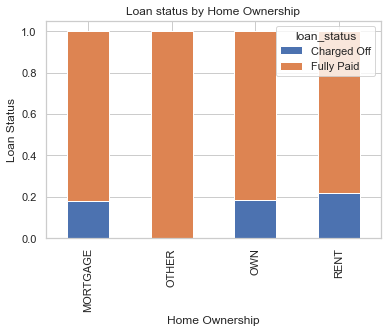

In [50]:
home_ownership_xt_pct = home_ownership_xt.div(home_ownership_xt.sum(1).astype(float), axis=0)

home_ownership_xt_pct.plot(kind='bar', 
                   stacked=True, 
                   title='Loan status by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Loan Status')

Charge off rates are higher for Rent and Own home owner ship with 23% and 21% respectively

In [51]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE   0.18
OWN        0.19
RENT       0.22
Name: loan_status, dtype: float64

#### Verification Status

In [52]:
loans.groupby('verification_status')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

verification_status
Not Verified      0.14
Source Verified   0.20
Verified          0.24
Name: loan_status, dtype: float64

Charge off rates are higher for Verified compared to other two types

#### Purpose

In [53]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    6704
RENT        5434
OWN         1392
OTHER          6
Name: home_ownership, dtype: int64

In [54]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

purpose
car                  0.11
credit_card          0.17
debt_consolidation   0.21
home_improvement     0.17
house                0.31
major_purchase       0.20
medical              0.25
moving               0.23
other                0.18
renewable_energy     0.12
small_business       0.33
vacation             0.17
wedding              0.12
Name: loan_status, dtype: float64

#### Title

In [55]:
loans['title'].describe()

count                  13401
unique                  1147
top       Debt consolidation
freq                    6638
Name: title, dtype: object

In [56]:
loans['title'].value_counts().head

<bound method NDFrame.head of Debt consolidation                                                          6638
Credit card refinancing                                                     2592
Home improvement                                                             780
Other                                                                        665
Major purchase                                                               255
Debt Consolidation                                                           149
Medical expenses                                                             142
Car financing                                                                123
Business                                                                     108
Moving and relocation                                                         76
Vacation                                                                      66
Consolidation                                                                 5

Purpose and Title are quite similar so we can drop either one column

In [57]:
loans.drop('title', axis=1, inplace=True)

#### Zip code and Address state 

In [58]:
loans['zip_code'].describe()

count     13536
unique      824
top       112xx
freq        138
Name: zip_code, dtype: object

In [59]:
loans['addr_state'].sample(5)

363216     WA
1510895    CT
1819260    NY
1303736    MO
1792251    KY
Name: addr_state, dtype: object

In [60]:
loans['addr_state'].nunique()

50

Zip code and address are quite similar which tells about address of applicant, so we will drop one column with more unique values

In [61]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
HI   0.09
OR   0.10
WV   0.11
MA   0.13
CO   0.14
RI   0.15
SD   0.16
WY   0.16
WA   0.16
GA   0.16
IL   0.17
MN   0.17
NV   0.17
WI   0.17
SC   0.18
DC   0.18
NH   0.18
CA   0.18
AL   0.19
IN   0.19
VT   0.19
NM   0.19
NE   0.19
AZ   0.20
MO   0.21
MI   0.21
CT   0.21
TX   0.21
FL   0.21
PA   0.21
VA   0.21
OH   0.21
KY   0.21
TN   0.21
KS   0.22
NY   0.22
MS   0.22
UT   0.22
MT   0.22
MD   0.22
NC   0.23
NJ   0.23
LA   0.23
OK   0.23
AK   0.24
ND   0.25
DE   0.27
AR   0.29
ID   0.33
Name: loan_status, dtype: float64

MS state having highest charge off rates with 26%

In [62]:
loans.drop(labels='zip_code', axis=1, inplace=True)

#### Initial list status

In [63]:
loans['initial_list_status'].describe()

count     13536
unique        2
top           w
freq       7835
Name: initial_list_status, dtype: object

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


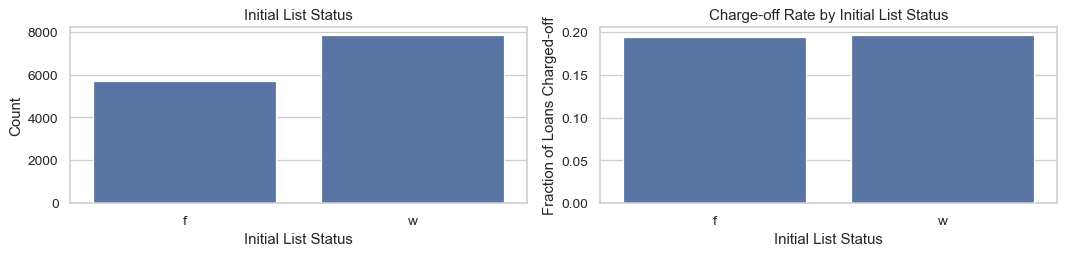

In [64]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

Charge off rates for "w" and "f" status are similar with 20%

#### Application type

In [65]:
loans['application_type'].value_counts(normalize=True)

Individual   0.98
Joint App    0.02
Name: application_type, dtype: float64

In [66]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual   0.20
Joint App    0.21
Name: loan_status, dtype: float64

2% Loan applicants are Joint application types which are having 25% of charge off rates 

### Analyzing Numerical Data

#### Loan amount

In [67]:
loans['loan_amnt'].describe()

count   13,536.00
mean    14,366.39
std      8,706.38
min      1,000.00
25%      7,875.00
50%     12,000.00
75%     20,000.00
max     40,000.00
Name: loan_amnt, dtype: float64

In [68]:
loans['loan_amnt'] = loans['loan_amnt'].apply(lambda x: np.log10(x+1)) #applying log10 to calculate numerical value

In [69]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,646.00",4.12,0.29,3.00,3.97,4.18,4.32,4.60
Fully Paid,"10,890.00",4.05,0.30,3.00,3.87,4.08,4.30,4.60


#### Interest Rate

In [70]:
loans['int_rate'].describe()

count   13,536.00
mean        13.25
std          4.77
min          5.31
25%          9.76
50%         12.74
75%         15.99
max         30.99
Name: int_rate, dtype: float64

In [71]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,646.00",15.75,5.01,5.31,12.39,15.05,18.55,30.99
Fully Paid,"10,890.00",12.64,4.51,5.31,9.17,12.29,15.10,30.99


In [72]:
loans.groupby('purpose')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
purpose,,,,,,,,
car,169.00,12.03,4.23,5.32,8.90,11.53,14.46,26.77
credit_card,"3,026.00",11.78,4.22,5.31,8.24,11.44,13.99,30.99
debt_consolidation,"7,790.00",13.64,4.74,5.31,10.48,13.18,16.29,30.99
educational,1.00,11.36,nan,11.36,11.36,11.36,11.36,11.36
home_improvement,903.00,12.65,4.83,5.32,8.90,12.29,15.41,30.74
house,58.00,15.34,5.04,7.24,12.03,14.25,18.78,28.72
major_purchase,309.00,13.00,4.71,5.32,9.49,12.69,15.49,29.99
medical,159.00,13.78,4.90,5.31,10.42,13.49,16.38,28.72
moving,92.00,15.58,5.43,6.00,11.99,14.82,19.29,30.99


In [73]:
loans.groupby('sub_grade')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
sub_grade,,,,,,,,
A1,439.00,5.53,0.32,5.31,5.32,5.32,6.03,6.46
A2,393.00,6.55,0.32,5.79,6.24,6.49,6.62,7.68
A3,359.00,7.10,0.31,6.17,6.89,6.99,7.24,8.00
A4,541.00,7.50,0.32,6.54,7.26,7.49,7.69,8.60
A5,623.00,8.18,0.42,6.91,7.89,7.97,8.39,9.25
B1,713.00,8.90,0.69,8.18,8.24,8.67,9.44,10.95
B2,683.00,9.93,0.73,9.16,9.17,9.93,10.49,11.48
B3,835.00,10.76,0.85,9.62,9.99,10.49,11.55,12.12
B4,846.00,11.49,0.81,9.99,10.91,10.99,11.67,13.11


#### Installment

In [74]:
loans['installment'].describe()

count   13,536.00
mean       436.72
std        260.21
min         14.01
25%        247.26
50%        372.45
75%        580.24
max      1,569.11
Name: installment, dtype: float64

In [75]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,646.00",475.62,267.55,30.54,278.29,418.65,634.95,"1,569.11"
Fully Paid,"10,890.00",427.27,257.53,14.01,239.95,362.43,567.30,"1,415.78"


#### Annual Income

In [76]:
loans['annual_inc'].describe()

count      13,536.00
mean       75,976.01
std        53,097.74
min             0.00
25%        46,000.00
50%        65,000.00
75%        91,000.00
max     1,600,001.00
Name: annual_inc, dtype: float64

In [77]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [78]:
loans.drop('annual_inc', axis=1, inplace=True)

In [79]:
loans['log_annual_inc'].describe()

count   13,536.00
mean         4.81
std          0.25
min          0.00
25%          4.66
50%          4.81
75%          4.96
max          6.20
Name: log_annual_inc, dtype: float64

In [80]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,646.00",4.79,0.24,0.00,4.65,4.80,4.93,6.00
Fully Paid,"10,890.00",4.82,0.25,0.00,4.67,4.81,4.97,6.20


#### Debt to Income ratio

In [81]:
loans['dti'].describe()

count   13,531.00
mean        18.36
std         12.86
min          0.00
25%         11.85
50%         17.60
75%         23.97
max        999.00
Name: dti, dtype: float64

In [82]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,645.00",20.41,21.09,0.00,13.57,19.82,26.19,999.00
Fully Paid,"10,886.00",17.87,9.81,0.00,11.55,17.10,23.44,369.37


#### FICO range

In [83]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,"13,536.00","13,536.00"
mean,696.03,700.03
std,31.88,31.88
min,660.00,664.00
25%,670.00,674.00
50%,690.00,694.00
75%,710.00,714.00
max,845.00,850.00


In [84]:
loans[['fico_range_low','fico_range_high']].corr() #Calculating correlation

,fico_range_low,fico_range_high
fico_range_low,1.00,1.00
fico_range_high,1.00,1.00


In [85]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [86]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

In [87]:
loans.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,646.00",689.91,26.08,662.00,672.00,682.00,702.00,837.00
Fully Paid,"10,890.00",700.01,32.83,662.00,677.00,692.00,717.00,847.50


#### Open credit lines and Total accounts

In [88]:
loans[['open_acc','total_acc']].corr()

,open_acc,total_acc
open_acc,1.00,0.69
total_acc,0.69,1.00


In [89]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,646.00",11.99,5.43,1.00,8.00,11.00,15.00,49.00
Fully Paid,"10,890.00",11.45,5.35,1.00,8.00,10.00,14.00,59.00


In [90]:
loans['acc_ratio'] = loans['open_acc'] / loans['total_acc']

In [91]:
loans.drop(['total_acc','open_acc'], axis=1, inplace=True)

#### Public records and Public records brankrupticies

In [92]:
loans[['pub_rec','pub_rec_bankruptcies']].corr()

,pub_rec,pub_rec_bankruptcies
pub_rec,1.00,0.58
pub_rec_bankruptcies,0.58,1.00


In [93]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,646.00",0.24,0.60,0.00,0.00,0.00,0.00,10.00
Fully Paid,"10,890.00",0.22,0.76,0.00,0.00,0.00,0.00,49.00


In [94]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.00    11866
1.00     1552
2.00       87
3.00       18
4.00        4
5.00        2
7.00        1
Name: pub_rec_bankruptcies, dtype: int64

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


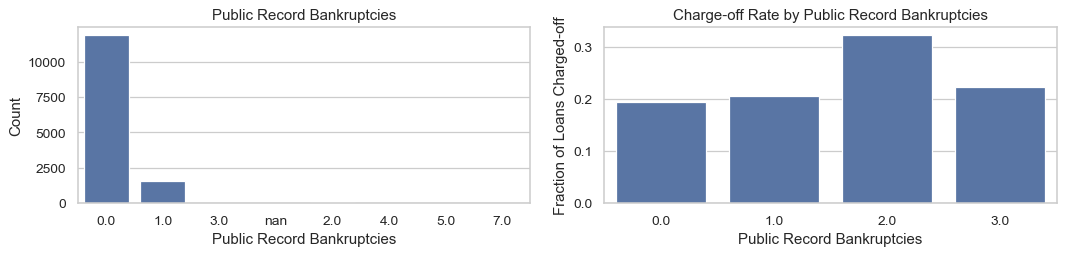

In [95]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

In [96]:
loans.drop('pub_rec', axis=1, inplace=True)

#### Revolving balance

In [97]:
loans['revol_bal'].describe()

count    13,536.00
mean     16,361.82
std      21,933.89
min           0.00
25%       5,965.00
50%      11,070.50
75%      19,809.00
max     609,131.00
Name: revol_bal, dtype: float64

In [98]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [99]:
loans.drop('revol_bal', axis=1, inplace=True)

#### Revolving util

In [100]:
loans['revol_util'].describe()

count   13,530.00
mean        51.80
std         24.39
min          0.00
25%         33.60
50%         52.00
75%         70.80
max        139.90
Name: revol_util, dtype: float64

In [101]:
loans[['revol_util','fico_score']].corr()

,revol_util,fico_score
revol_util,1.00,-0.45
fico_score,-0.45,1.00


In [102]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,645.00",55.17,23.60,0.00,38.20,56.00,72.90,106.60
Fully Paid,"10,885.00",50.98,24.51,0.00,32.60,51.00,70.20,139.90


#### Mortgage account

In [103]:
loans['mort_acc'].describe()

count   13,061.00
mean         1.66
std          2.03
min          0.00
25%          0.00
50%          1.00
75%          3.00
max         25.00
Name: mort_acc, dtype: float64

In [104]:
loans.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,"2,577.00",1.39,1.84,0.00,0.00,1.00,2.00,15.00
Fully Paid,"10,484.00",1.73,2.07,0.00,0.00,1.00,3.00,25.00


### Date type columns

In [105]:
loans['issue_d'].sample(5)

258107     Jun-2015
560589     Sep-2017
1864636    Mar-2013
407127     Jan-2015
2056354    Dec-2017
Name: issue_d, dtype: object

In [106]:
loans['earliest_cr_line'].sample(5)

2167067    Dec-2000
312416     Nov-2003
1155640    Sep-2004
2150486    Feb-2007
1831503    Apr-1990
Name: earliest_cr_line, dtype: object

In [107]:
loans['earliest_cr_line'].isnull().any()

False

In [108]:
loans['issue_d'].isnull().any()

False

In [109]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

Text(0.5, 1.0, 'Loans Funded per Year')

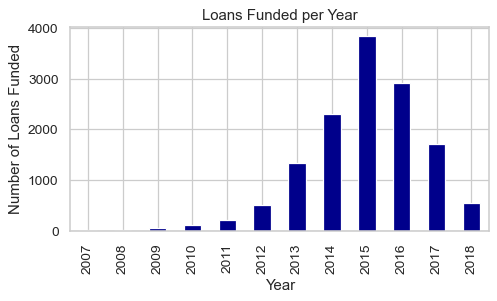

In [110]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

In [111]:
loans['earliest_cr_line'] = pd.to_datetime(loans['earliest_cr_line'])

Calculate number of days between issue date and earliest credit lines, so that we know the days of applicant with the bank

In [112]:
loans['days_from_issue_to_earliest_cr'] = (loans['issue_d'] - loans['earliest_cr_line']).apply(lambda x: x.days)

In [113]:
loans['days_from_issue_to_earliest_cr'].sample(5)

1032418    5844
1814345    5053
1338713    4505
1269941    7029
689544     1430
Name: days_from_issue_to_earliest_cr, dtype: int64

In [114]:
loans['target'] = (loans['loan_status'] == 'Charged Off').astype(int)
loans['target'].describe()

count   13,536.00
mean         0.20
std          0.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: target, dtype: float64

In [115]:
_df = loans.groupby('days_from_issue_to_earliest_cr')['target'].mean().reset_index()

<AxesSubplot:xlabel='days_from_issue_to_earliest_cr', ylabel='target'>

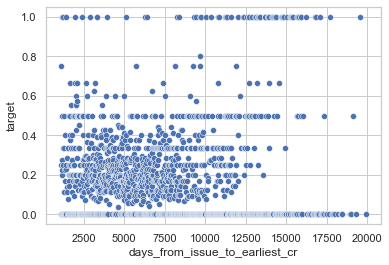

In [116]:
sns.scatterplot(x='days_from_issue_to_earliest_cr', y='target', data=_df)

In [117]:
_df.corr()

,days_from_issue_to_earliest_cr,target
days_from_issue_to_earliest_cr,1.00,0.02
target,0.02,1.00


In [118]:
loans.drop(['target','earliest_cr_line'],axis=1,inplace=True)

#### More Pre preprocessing

Convert charge off in loan status as 0/1 indicator

In [119]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [120]:

missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [121]:

print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

mort_acc               0.04
pub_rec_bankruptcies   0.00
revol_util             0.00
dti                    0.00
dtype: float64


In [122]:

print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'revol_util', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies',
       'log_annual_inc', 'fico_score', 'acc_ratio', 'log_revol_bal',
       'days_from_issue_to_earliest_cr', 'charged_off'],
      dtype='object')


Create dummy variables for categorical data

In [123]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status','application_type'], drop_first=True)



In [124]:
loans.shape

(13536, 119)

In [125]:
import pyarrow.feather as feather
feather.write_feather(loans,'./loans_modelling_data')

C:\Users\user\miniconda3\envs\sm-202011\lib\site-packages\pyarrow\feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):
